In [1]:
import numpy as np
from copy import deepcopy
import dionysus as d
import scipy
import pandas as pd
import gudhi as gd
from collections import Counter
import networkx as nx


from Laplacian_Functions import *
from Ren_Functions import *

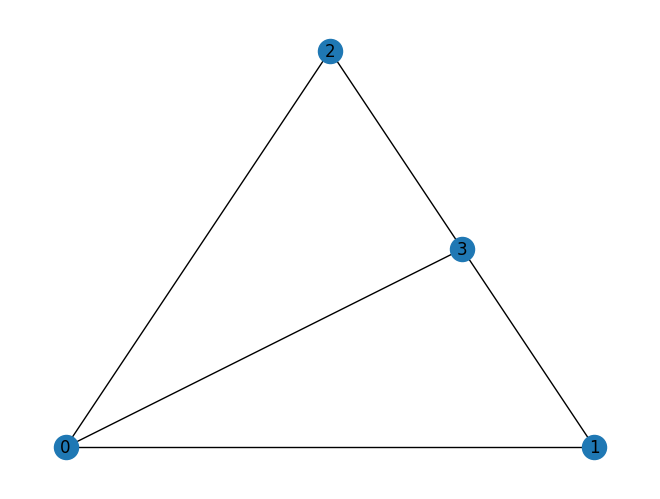

In [2]:
def create_cycle(n, start_n = 0):
    simplices = []
    for v_i in range(n):
        simplices.append(([v_i+start_n], 0))
        simplices.append(([v_i+start_n, (v_i+1)%n+start_n], 1))
    return simplices
    

# Drawn
simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 5), ([1,3], 6), ([2,3], 7), ([0,2], 8), ([0,1,3], 9)]#, ([0,2,3], 10)]

# Test
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 0), ([0,2], 1), ([0,3], 1), ([2,3], 1), ([0,1], 2), ([0,2,3], 3)]

# Drawn new
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 1), ([0,1], 2), ([1,2], 2), ([2,3], 2), ([0,2], 3), ([0,3], 3), ([4], 4), ([2,4], 5), ([3,4], 5), ([0,1,2], 6), ([2,3,4], 7)]#, ([0,2,3], 8)]

# Cycles
# x = 2
# y = 2
# overlap = 1
# simplices = create_cycle(x) + create_cycle(y, start_n=x-overlap)
# simplices.append(([7], 0))
# simplices.append(([6,7], 1))
# simplices = create_cycle(7)
# simplices.append(([10], 2))
# simplices.append(([0,2], 2))
# simplices.append(([0,1,2], 2))
# simplices.append(([0,3], 3))
# simplices.append(([0,2,3], 3))
# print(simplices)

f = d.Filtration()
for vertices, time in simplices:
    f.append(d.Simplex(vertices, time))

# Drawing graph
G = nx.Graph()
f.sort()
for s in f:
    if s.dimension() == 0:
        G.add_node(s[0])
    elif s.dimension() == 1:
        G.add_edge(s[0], s[1])
nx.draw_planar(G, with_labels=True)

In [4]:
def weight_fun(x):
    v = x.split(",")
    p = 1
    if "1" in v:
        p *= 2**(len(v)/2)
    # if "3" in v:
    #     p *= 3**(len(v)/2)
    return p


compute_Laplacian(f, 1, 9, 9, weight_fun, verb=True)

upL:
 [[ 2. -4.  2.  0.  0.]
 [-4.  8. -4.  0.  0.]
 [ 2. -4.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
eval: 0.0, evec: [-5. -2.  1.  0.  0.]
eval: 12.0, evec: [-1.  2. -1.  0.  0.]
eval: 0.0, evec: [-5. -2.  1.  0.  0.]
eval: 0.0, evec: [0. 0. 0. 1. 0.]
eval: 0.0, evec: [0. 0. 0. 0. 1.]
Product of eigenvalues: 12.0

downL:
 [[ 6.  2. -2.  0.  2.]
 [ 2.  2.  2.  1.  1.]
 [-2.  2.  6.  2.  0.]
 [ 0.  1.  2.  2. -1.]
 [ 2.  1.  0. -1.  2.]]
eval: 8.7, evec: [-2.85 -0.    2.85  1.   -1.  ]
eval: 7.0, evec: [-2. -2. -2. -1. -1.]
eval: 0.0, evec: [-1.5  2.  -1.5  1.   1. ]
eval: 2.3, evec: [-1.    0.    1.   -2.85  2.85]
eval: 0.0, evec: [  -1.   -168.84   -1.    170.84  170.84]
Product of eigenvalues: 140.0



array([[ 8.0000000e+00, -2.0000000e+00,  8.8817842e-16,  0.0000000e+00,
         2.0000000e+00],
       [-2.0000000e+00,  1.0000000e+01, -2.0000000e+00,  1.0000000e+00,
         1.0000000e+00],
       [ 8.8817842e-16, -2.0000000e+00,  8.0000000e+00,  2.0000000e+00,
         0.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00,  2.0000000e+00,  2.0000000e+00,
        -1.0000000e+00],
       [ 2.0000000e+00,  1.0000000e+00,  0.0000000e+00, -1.0000000e+00,
         2.0000000e+00]])

In [6]:
compute_Laplacian(f, 0, 3, 5, lambda x: 1)

array([[ 2., -1.,  0., -1.],
       [-1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  1.]])

In [123]:
def weight_fun(x):
    if "1" in x:
        return 1
    return 1


barcodes_df = complete_analysis_fast(f, weight_fun)
# print(np.round(barcodes_df.loc[2, "p_ij"], 2))
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,0,1.0,2,"[0.0, 0.0, 0.0]","[-0.0, 1.0, 3.0]",[],[],1,3.0,1,1
1,0,inf,1,"[0.0, 0.0, 0.0]","[-0.0, 1.0, 3.0]",[],[],1,3.0,1,1


""


In [120]:
for x in range(3, 7):
    for y in range(3, 7):
        overlap = 3
        simplices = create_cycle(x) + create_cycle(y, start_n=x-overlap)

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        barcodes_df = complete_analysis_fast(f, weight_fun)
        print(f"x: {x}, y: {y}||", np.round(barcodes_df.loc[2, "p_ij"], 2))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 3, y: 3|| 9.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 3, y: 4|| 32.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 3, y: 5|| (55+0j)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 3, y: 6|| 84.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 4, y: 3|| 32.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 4, y: 4|| 60.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 4, y: 5|| 96.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 4, y: 6|| 140.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 5, y: 3|| 55.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 5, y: 4|| 96.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 5, y: 5|| 147.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 5, y: 6|| 208.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 6, y: 3|| 84.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 6, y: 4|| 140.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 6, y: 5|| 208.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

x: 6, y: 6|| 288.0


In [7]:
def weight_fun(x):
    v = x.split(",")
    if "2" in v:
        return 2**(len(v)/2)
    return 1

barcodes_df = complete_analysis_fast(f, weight_fun)
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,1.0,4.0,1,"[0.0, 0.0]","[0.0, 2.0]",[0.0],[0.0],1.0,2.0,1.0,1.0
1,3.0,5.0,1,"[0.0, 0.0, 0.0, 2.0]","[-0.0, 0.0, 1.0, 3.0]","[0.0, 0.0, 2.0]","[0.0, 0.0, 2.0]",2.0,3.0,2.0,2.0
2,2.0,7.0,1,"[-0.0, 0.0, 3.0]","[-0.0, 1.33, 3.0]","[-0.0, 3.0]","[0.0, 3.0]",3.0,4.0,3.0,3.0
3,0.0,inf,1,[0.0],[0.0],[],[],1.0,1.0,1.0,1.0


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
4,6.0,9.0,1,"[-0.0, 3.0, 3.0]","[3.0, 3.0, 3.0]","[1.0, 3.0]","[1.0, 3.0]",9.0,27.0,3.0,3.0
5,8.0,inf,1,"[0.0, -0.0, 2.3, 7.0, 8.7]","[0.0, 2.3, 3.0, 7.0, 8.7]","[-0.0, 1.3, 3.0, 7.7]","[1.3, 3.0, 3.0, 7.7]",140.0,420.0,30.0,90.0


""


In [6]:
def weight_fun(x):
    return 1

barcodes_df = complete_analysis_fast(f, weight_fun)
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,1.0,4.0,1,"[0.0, 0.0]","[0.0, 2.0]",[0.0],[0.0],1.0,2.0,1.0,1.0
1,3.0,5.0,1,"[0.0, 0.0, 0.0, 2.0]","[-0.0, 0.0, 1.0, 3.0]","[0.0, 0.0, 2.0]","[0.0, 0.0, 2.0]",2.0,3.0,2.0,2.0
2,2.0,7.0,1,"[-0.0, 0.0, 3.0]","[0.0, 1.0, 3.0]","[-0.0, 3.0]","[-0.0, 3.0]",3.0,3.0,3.0,3.0
3,0.0,inf,1,[0.0],[0.0],[],[],1.0,1.0,1.0,1.0


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
4,6.0,9.0,1,"[-0.0, 3.0, 3.0]","[3.0, 3.0, 3.0]","[1.0, 3.0]","[1.0, 3.0]",9.0,27.0,3.0,3.0
5,8.0,inf,1,"[0.0, -0.0, 2.0, 4.0, 4.0]","[-0.0, 2.0, 3.0, 4.0, 4.0]","[-0.0, 1.0, 3.0, 4.0]","[1.0, 3.0, 3.0, 4.0]",32.0,96.0,12.0,36.0


""


In [7]:
def weight_fun(x):
    # v = x.split(',')
    # if v != "2" and "2" in v: #and len(v) >= 2:
    #     return 2 ** len(v)
    if "2" in x:
        return 2
    # if x in ["0,1,3"]:
    #     return 3
    return 1

ren_df = complete_analysis_Ren_fast(f, weight_fun)
ren_df

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

,q,birth,death,multiplicity,torsion_ijm1,torsion_ij,torsion_im1jm1,torsion_im1j,Weight
0,0,0.0,inf,1,None,[],None,[],[]
1,0,1.0,4.0,1,[],[],[],[],[]
2,0,2.0,7.0,1,[],[],[],[],[]
3,0,3.0,5.0,1,[],[],[],[],[]
4,1,6.0,9.0,1,[],[],[],[],[]
5,1,8.0,inf,1,None,[],None,[],[]


In [ ]:
f.sort()
p = d.cohomology_persistence(f, 47, True)
dgms = d.init_diagrams(p, f)
for q in range(len(dgms)):
    for point in dgms[q]:
        


In [5]:
def list_minus(x, y):
    counter_x = Counter(x)
    counter_y = Counter(y)

    c_xmy = counter_x - counter_y
    return list(c_xmy.elements())

ren_df.apply(lambda x: help_f(help_f(x["torsion_ij"], x["torsion_ijm1"]), help_f(x["torsion_im1j"], x["torsion_im1jm1"])), axis=1)

0    [2.0]
1       []
2       []
3       []
4       []
5       []
dtype: object

In [37]:


def weight_fun(x):
    return 1


barcodes_df = complete_analysis_fast(f, weight_fun)
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)


# barcodes_p_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None), axis=1).groupby("q").apply(display)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,1.0,4.0,1,"[0.0, 0.0]","[0.0, 2.0]",[0.0],[0.0],1.0,2.0,1.0,1.0
1,3.0,5.0,1,"[0.0, 0.0, 0.0, 2.0]","[-0.0, 0.0, 1.0, 3.0]","[0.0, 0.0, 2.0]","[0.0, 0.0, 2.0]",2.0,3.0,2.0,2.0
2,2.0,7.0,1,"[-0.0, 0.0, 3.0]","[0.0, 1.0, 3.0]","[-0.0, 3.0]","[-0.0, 3.0]",3.0,3.0,3.0,3.0
3,0.0,inf,1,[0.0],[0.0],[],[],1.0,1.0,1.0,1.0


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
4,6.0,9.0,1,"[-0.0, 3.0, 3.0]","[3.0, 3.0, 3.0]","[1.0, 3.0]","[1.0, 3.0]",9.0,27.0,3.0,3.0
5,8.0,10.0,1,"[-0.0, 2.0, 3.0, 4.0, 4.0]","[2.0, 2.0, 4.0, 4.0, 4.0]","[1.0, 3.0, 3.0, 4.0]","[1.0, 3.0, 3.0, 4.0]",96.0,256.0,36.0,36.0


""


In [39]:
def weight_fun(x):
    # v = x.split(',')
    # if v != "2" and "2" in v and len(v) >= 2:
    #     return 2
    if x in ["0,2,3"]:
        return 3
    # if x in ["0,2,3"]:
    #     return 2
    return 1

barcodes_df = complete_analysis_fast(f, weight_fun, max_dim=2)
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 3) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,0.0,1.0,2,"[0.0, 0.0, 0.0, 0.0]","[-0.0, 0.0, 3.0, 3.0]",[],[],1.0,9.0,1,1
1,0.0,2.0,1,"[-0.0, 0.0, 3.0, 3.0]","[0.0, 1.0, 3.0, 4.0]",[],[],9.0,12.0,1,1
2,0.0,inf,1,"[0.0, 1.0, 3.0, 4.0]","[0.0, 1.0, 3.0, 4.0]",[],[],12.0,12.0,1,1


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
3,1.0,3.0,1,"[-0.0, 3.0, 3.0]","[3.0, 3.0, 27.0]",[],[],9.0,243.0,1,1


""


In [41]:
def id_fun(x):
    return 1

def weight_fun(x):
    # v = x.split(',')
    # if v != "2" and "2" in v and len(v) >= 2:
    #     return 2
    if x in ["0,2,3"]:
        return 2
    # if x in ["0,1,3"]:
    #     return 3
    return 1

# barcodes_df = complete_analysis(f, id_fun)
id_barcodes_df = complete_analysis(f, id_fun)
# id_barcodes_full_df = barcodes_df.merge(barcodes_p_df, how="right", on=["q", "birth", "death", "multiplicity"])

# barcodes_df = complete_analysis(f, weight_fun)
weight_barcodes_p_df = complete_analysis(f, weight_fun)
# weighted_barcodes_full_df = barcodes_df.merge(barcodes_p_df, how="right", on=["q", "birth", "death", "multiplicity"])

weighted_barcodes_df = None
weighted_barcodes_df = id_barcodes_df[["q", "birth", "death", "multiplicity"]]
weighted_barcodes_df.insert(4, "value", id_barcodes_df["p_ij"]/(id_barcodes_df["p_im1jm1"]))
weighted_barcodes_df.insert(5, "weight", ((weight_barcodes_p_df.loc[:, "p_ij"]/(weight_barcodes_p_df.loc[:, "p_im1jm1"])) / (weighted_barcodes_df["value"])).pow(0.5))
weighted_barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 4) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,birth,death,multiplicity,value,weight
0,0.0,1.0,2.0,9.0,1.0
1,0.0,2.0,1.0,12.0,1.0
2,0.0,inf,1.0,12.0,1.0


,birth,death,multiplicity,value,weight
3,1.0,3.0,1.0,27.0,2.0


""


In [139]:
A = np.arange(6).reshape((3,2))
print(A, A.shape)
B = np.arange(4).reshape((2,2))
print(B, B.shape)
(A@B)

[[0 1]
 [2 3]
 [4 5]] (3, 2)
[[0 1]
 [2 3]] (2, 2)


array([[ 2,  3],
       [ 6, 11],
       [10, 19]])